<a href="https://colab.research.google.com/github/cbadenes/phd-thesis/blob/master/notebooks/soa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook supports the state-of-the-art content of the thesis: *Semantically-enabled Browsing of Large Multilingual Document Collections, Badenes-Olmedo, C. 2021*

# 2.- Techniques for Document Retrieval

The analysis of human-readable documents is a well-known problem in Artificial Intelligence (AI) in general, and in the Information Retrieval (IR) and Natural Language Processing (NLP) fields in particular. As an academic field of study, information retrieval might be defined as finding documents of an unstructured nature, usually text, that satisfies an information need from within large collections (Manning et al., 2008). As defined in this way, hundreds of millions of people engage in information retrieval every day when they use a web search engine or search their email. Information retrieval is fast becoming the dominant form of information access, surpassing traditional database searching where identifiers are needed to have results.

There are two major categories of IR technology and research: semantic and statistical. Semantic approaches attempt to implement some degree of syntactic and semantic analysis. They try to reproduce to some degree the understanding of the natural language text that a human user would provide. In statistical approaches, the documents that are retrieved or that are highly ranked are those that match the query most closely in terms of some statistical measure. The work presented in this thesis follows this second approach.

## 2.1.- Load Corpus

An illustrative example may help to better understand IR techniques, so the publications listed in Section 1.1 are used as a sample collection for applying each of them.

In [41]:
import requests
import json
import pandas as pd

#increase the max column length
pd.set_option('display.max_colwidth', 200)

corpus_df = pd.read_csv('https://www.dropbox.com/s/pag5jseq2e9wcvb/corpus.csv?raw=1',usecols=['title','text'])
corpus_df

,title,text
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc..."
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber..."
3,Distributing Text Mining tasks with librAIry,"Distributing Text Mining tasks with librAIry Carlos Badenes-Olmedo cbadenes@f.upm.es Universidad Polit´ecnica de Madrid Ontology Engineering Group Boadilla del Monte, Spain Jos´e Luis Redondo-Garc..."
4,Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms,"Semantic Web 0 (0) 1 1 IOS Press Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms Editor(s): Tomi Kauppinen, Aalto University, Finland; Daniel Garijo,..."
5,An initial Analysis of Topic-based Similarity among Scientific Documents based on their Rhetorical Discourse Parts,"An initial Analysis of Topic-based Similarity among Scientific Documents based on their Rhetorical Discourse Parts Carlos Badenes-Olmedo1, Jos´e Luis Redondo-Garc´ıa2, and Oscar Corcho1 1 Universi..."
6,Efficient Clustering from Distributions over Topics,"Efficient Clustering from Distributions over Topics Carlos Badenes-Olmedo cbadenes@￿.upm.es Ontology Engineering Group Universidad Polit´ecnica de Madrid Boadilla del Monte, Spain Jos´e Luis Redon..."
7,Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets,Cross-lingual annotations of legislative texts enable us to explore major themes covered in multi- lingual legal data and are a key facilitator of semantic similarity when searching for similar do...
8,Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies,"Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies Carlos Badenes-Olmedo cbadenes@fi.upm.es Ontology Engineering Group, Universidad Politécnica de Madrid Boad..."
9,Potentially inappropriate medications in older adults living with HIV,"Potentially inappropriate medications in older adults living with HIV B L�opez-Centeno,1,* C Badenes-Olmedo,2 A Mataix-Sanjuan,1 JM Bell�on,3 L P�erez-Latorre,3 JC L�opez,3 J Bened�ı,4,* S Khoo,5 ..."


## 2.2. Text Pre-Processing

Documents must be pre-processed to transform their texts into terms. These terms are the population that is counted and measured statistically. Most commonly, the terms are words (or combination of adjacent words or characters) that occur in a given query or collection of documents and often require pre-processing. 

### 2.2.1: Methods to transform texts into terms

Words are reduced to a common base form by using a heuristic process that removes affixes, stemming, or by returning its dictionary form, lemma (Porter, 1997). The objective is to eliminate the variation that arises from the occurrence of different grammatical forms of the same word, e.g., ”program”, ”programming”, ”programs”, and ”programmed” should all be recognized as forms of the same word, ”program”.

Another common form of pre-processing is the elimination of common words that have little power to discriminate relevant from non-relevant documents,e.g., ”the”, ”a”, ”it”. Hence, IR engines are usually provided with a stop-list of such noise words. Note that both stemming/lemma and stopwords are language-dependent.

In [42]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

nlp = spacy.load("en_core_web_sm")

def tokenize(text):
  tokens = nlp(text)
  return tokens

def is_valid(token):
  return len(token.text) > 1 and not token.is_digit and not token.is_stop

def lemma(token):
  return token.lemma_

def preprocess(text):
  tokens = []
  for token in tokenize(text):
    if is_valid(token): 
      tokens.append(lemma(token))
  return tokens

print("methods created succesfully")

methods created succesfully


The following sentence taken from one of the documents can be used to see each of the steps: *”Probabilistic Topic Models reduce that feature space by annotating documents with thematic information”*.

In [43]:
tokens = preprocess("Probabilistic Topic Models reduce that feature space by annotating documents with thematic information")
print(tokens)

['Probabilistic', 'Topic', 'Models', 'reduce', 'feature', 'space', 'annotate', 'document', 'thematic', 'information']


At this step ’annotating’ was transformed to ’annotate’ and ’documents’ was reduced to ’document’. However, ’Models’ remains unchanged. The reason is that since it starts with a capital letter, it is considered a proper noun. Finally, those words that appear in a stop-word list are removed (e.g. ’that’, ’by’ and ’with’). Each text is transformed into a normalized list of terms.

### 2.2.2. Count words

In [44]:
def count_words(text):
  return len(text.split(" "))

corpus_df['#words'] = corpus_df['text'].apply(count_words)
corpus_df.head(3)

,title,text,#words
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417


### 2.2.3. Tokenize Corpus

In [45]:
corpus_df['tokens'] = corpus_df['text'].apply(preprocess)

corpus_df.head(3)

,title,text,#words,tokens
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall..."
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ..."
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc..."


### 2.2.4. Count tokens

In [46]:
def count_tokens(tokens):
  return len(tokens)

corpus_df['#tokens'] = corpus_df['tokens'].apply(count_tokens)

corpus_df.head(3)

,title,text,#words,tokens,#tokens
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall...",6342
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ...",3406
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc...",3260


### 2.2.5 Some statistics

In [47]:
unique_tokens = []

for pos in range(len(corpus_df.index)):
  num_words = corpus_df['#words'][pos]
  num_tokens = corpus_df['#tokens'][pos]
  num_unique_tokens = len(set(corpus_df['tokens'][pos]))
  unique_tokens.append(num_unique_tokens)  

corpus_df['#uni_tokens']=unique_tokens
corpus_df.head(3)

,title,text,#words,tokens,#tokens,#uni_tokens
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall...",6342,1618
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ...",3406,1290
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc...",3260,1367


## 2.3. Text Vectorization

Once all terms have been pre-processed, numerical weights are assigned to each them. The same term may have a different weight in each distinct document in which it occurs. The weight is usually a measure of how effective the given term is likely to be in distinguishing the given document from other documents in the given collection, and is often normalized to be a fraction between zero and one. Statistical approaches fall into the following categories: boolean, vector space and probabilistic.

In [48]:
all_tokens = []
for tokens in corpus_df['tokens']:
  all_tokens.extend(tokens)

vocabulary = list(set(all_tokens))
print("Vocabulary size:",len(vocabulary)," unique words(tokens)")
print("Vocabulary words:",vocabulary[1:10],"...")

Vocabulary size: 6182  unique words(tokens)
Vocabulary words: ['availability', 'Search', 'training', 'entry.n.03', 'emtricitabine', 'cal-', 'fnanced', 'Gatti', 'Vote'] ...


To encode our documents, we’ll create a vectorize function that creates a dictionary whose keys are the tokens in the document and whose values will depend on the approach we use.



The `defaultdic` object allows us to specify what the dictionary will return for a key that hasn’t been assigned to it yet. By setting `defaultdict(int)` we are specifying that a 0 should be returned, thus creating a simple counting dictionary. We can map this function to every item in the corpus creating an iterable of vectorized documents.

### 2.3.1. Boolean Approach

The Boolean representation sets true or false for each vocabulary word depending on whether or not it appears in the document.

In [49]:
from collections import defaultdict

def boolean_vectorize(tokens):
    features = defaultdict(bool)
    for token in tokens:
        features[token] = True
    return features

corpus_df['boolean'] = corpus_df['tokens'].apply(boolean_vectorize)
corpus_df.head(3)

,title,text,#words,tokens,#tokens,#uni_tokens,boolean
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall...",6342,1618,"{'synopsis': True, 'Refinements': True, 'Extensions': True, 'compare': True, 'publication': True, 'Conference': True, 'Proceedings': True, 'submission': True, 'refined': True, 'extended': True, 'p..."
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ...",3406,1290,"{'enhance': True, 'Public': True, 'Procurement': True, 'European': True, 'Union': True, 'Constructing': True, 'exploit': True, 'Integrated': True, 'Knowledge': True, 'Graph': True, 'Ahmet': True, ..."
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc...",3260,1367,"{'Drugs4Covid': True, 'make': True, 'drug': True, 'information': True, 'available': True, 'scientific': True, 'publication': True, 'Carlos': True, 'Badenes': True, 'Olmedo1': True, 'David': True, ..."


In the boolean approach, the query is formulated as a boolean combination of terms. A conventional boolean query uses the classical operators AND, OR, and NOT. The query ”t1 AND t2” is satisfied by a given document D1 if and only if D1 contains both terms t1 and t2. Similarly, the query ”t1 OR t2” is satisfied by D1 if and only if it contains t1 or t2 or both. The query ”t1 AND NOT t2” satisfies D1 if and only if it contains t1 and does not contain t2. More complex boolean queries can be built up out of these operators and evaluated according to the classical rules of boolean algebra. Such a boolean query is either true or false. Correspondingly, a document either satisfies such a query, i.e. is relevant, or does not satisfy it, i.e. is non-relevant. **No ranking is possible**, which is a significant limitation for this approach (Harmon, 1996).

For example, we can search for documents about topic hierarchies or multilinguality.

In [50]:
def relevant(doc):
  #return doc['HIV']
  return doc['multilingual'] or (doc['topic'] and doc['hierarchy'])
  #return doc['multilingual'] and doc['procurement']

result = []
pos = 0
for vector in corpus_df['boolean']:
  if relevant(vector):
    result.append(corpus_df['title'][pos])
  pos+=1 

for paper in result:
  print("-",paper)

- Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph
- Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms
- Efficient Clustering from Distributions over Topics
- Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets
- Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies


### 2.3.2 Vector space models

Vector space models (VSM) (Salton and McGill, 1983) were proposed to represent texts as vectors where each entry corresponds to a different term and the number at that entry corresponds to how many times that term is present in the text. The objective was twofold: on the one hand, making document collections manageable since we move from having lots of terms for each text to only one vector per document with a defined dimension; on the other hand, having representations based on metric spaces where calculations can be made, for example comparisons by measuring vector distances.

#### 2.3.2.1 Term-Frequency (TF)

The definition and number of dimensions for each vector are key aspects in a VSM. Based on the use of this type of model, traditional document retrieval tasks over collections of textual documents highly rely on individual features like term frequencies (TF) (Hearst and Hall, 1999). A representational space is created where each term in the vocabulary is projected by a separate and orthogonal dimension.

Vectors are created with the frequency of each word as it appears in the document. In this encoding scheme, each document is represented as the multiset of the tokens that compose it and the value for each word position in the vector is its count. This representation can either be a straight count (integer) encoding or a normalized encoding where each word is weighted by the total number of words in the document.

In [51]:
from collections import defaultdict

def tf_vectorize(tokens):
    features = defaultdict(int)
    for token in tokens:
        features[token] += 1
    return features

corpus_df['tf'] = corpus_df['tokens'].apply(tf_vectorize)
corpus_df.head(3)

,title,text,#words,tokens,#tokens,#uni_tokens,boolean,tf
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall...",6342,1618,"{'synopsis': True, 'Refinements': True, 'Extensions': True, 'compare': True, 'publication': True, 'Conference': True, 'Proceedings': True, 'submission': True, 'refined': True, 'extended': True, 'p...","{'synopsis': 1, 'Refinements': 1, 'Extensions': 1, 'compare': 21, 'publication': 3, 'Conference': 1, 'Proceedings': 1, 'submission': 2, 'refined': 2, 'extended': 1, 'paper': 44, 'base': 43, 'ICTER..."
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ...",3406,1290,"{'enhance': True, 'Public': True, 'Procurement': True, 'European': True, 'Union': True, 'Constructing': True, 'exploit': True, 'Integrated': True, 'Knowledge': True, 'Graph': True, 'Ahmet': True, ...","{'enhance': 9, 'Public': 9, 'Procurement': 9, 'European': 5, 'Union': 3, 'Constructing': 1, 'exploit': 1, 'Integrated': 8, 'Knowledge': 11, 'Graph': 11, 'Ahmet': 1, 'Soylu1': 1, 'Oscar': 1, 'Corch..."
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc...",3260,1367,"{'Drugs4Covid': True, 'make': True, 'drug': True, 'information': True, 'available': True, 'scientific': True, 'publication': True, 'Carlos': True, 'Badenes': True, 'Olmedo1': True, 'David': True, ...","{'Drugs4Covid': 24, 'make': 2, 'drug': 71, 'information': 11, 'available': 12, 'scientific': 14, 'publication': 9, 'Carlos': 1, 'Badenes': 10, 'Olmedo1': 1, 'David': 1, 'Chaves': 1, 'Fraga1': 1, '..."


The relevant results can now be sorted according to the frequency of the terms they contain. But **all terms in a document are treated as equally descriptive**.

In [52]:
def relevant(doc):
  # multiple scores for OR queries, the max value should be returned
  q1_score = 0
  q2_score = 0
  if doc['multilingual'] > 0:
    q1_score = doc['multilingual']
  if doc['topic'] > 0 and doc['hierarchy'] > 0:
    q2_score = doc['topic'] + doc['hierarchy']
  return max(q1_score, q2_score)

result = []
pos = 0
for vector in corpus_df['tf']:
  result.append({ 'title': corpus_df['title'][pos],
                 'score' : relevant(vector)})  
  pos+=1 

def sort_by_score(element):
  return element['score']

result.sort(reverse=True, key=sort_by_score)

for paper in result:
  print(paper)

{'title': 'Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms', 'score': 197}
{'title': 'Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies', 'score': 128}
{'title': 'Efficient Clustering from Distributions over Topics', 'score': 85}
{'title': 'Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets', 'score': 33}
{'title': 'Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph', 'score': 13}
{'title': 'Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation', 'score': 0}
{'title': 'Drugs4Covid: Making drug information available from scientific publications', 'score': 0}
{'title': 'Distributing Text Mining tasks with librAIry', 'score': 0}
{'title': 'An initial Analysis of Topic-based Similarity among Scientific Documents based on their Rhetorical Discourse Parts', 'score': 0}
{'title': 'Potentia

#### 2.3.2.2 Term-Frequency Inverse-Document-Frequency (TF/IDF)

To overcome this limitation, Term-Frequency Inverse-Document Frequency (TF-IDF) (Lee, 1995) relativizes the relevance of each term with respect to the entire corpus. TF-IDF calculates the importance of a term for a document, based on the number of times the term appears in the document itself (term frequency - TF) and the number of documents in the corpus, which contain the term (document frequency - DF).

In [53]:
# https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html
from collections import defaultdict
from nltk.text import TextCollection

texts  = TextCollection(corpus_df['tokens'])

vectors = []

for doc in corpus_df['tokens']:
  features = defaultdict(int)
  for term in doc:
    features[term]=texts.tf_idf(term, doc)
  vectors.append(features)

corpus_df['tf_idf'] = vectors
corpus_df.head(3)

,title,text,#words,tokens,#tokens,#uni_tokens,boolean,tf,tf_idf
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall...",6342,1618,"{'synopsis': True, 'Refinements': True, 'Extensions': True, 'compare': True, 'publication': True, 'Conference': True, 'Proceedings': True, 'submission': True, 'refined': True, 'extended': True, 'p...","{'synopsis': 1, 'Refinements': 1, 'Extensions': 1, 'compare': 21, 'publication': 3, 'Conference': 1, 'Proceedings': 1, 'submission': 2, 'refined': 2, 'extended': 1, 'paper': 44, 'base': 43, 'ICTER...","{'synopsis': 0.0003780976462942874, 'Refinements': 0.0003780976462942874, 'Extensions': 0.0003780976462942874, 'compare': 0.0003155966218686256, 'publication': 0.0002867245996075286, 'Conference':..."
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ...",3406,1290,"{'enhance': True, 'Public': True, 'Procurement': True, 'European': True, 'Union': True, 'Constructing': True, 'exploit': True, 'Integrated': True, 'Knowledge': True, 'Graph': True, 'Ahmet': True, ...","{'enhance': 9, 'Public': 9, 'Procurement': 9, 'European': 5, 'Union': 3, 'Constructing': 1, 'exploit': 1, 'Integrated': 8, 'Knowledge': 11, 'Graph': 11, 'Ahmet': 1, 'Soylu1': 1, 'Oscar': 1, 'Corch...","{'enhance': 0.004504619151540172, 'Public': 0.006336188330941086, 'Procurement': 0.006336188330941086, 'European': 0.0014850277622995888, 'Union': 0.0011444066213713397, 'Constructing': 0.00070402..."
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc...",3260,1367,"{'Drugs4Covid': True, 'make': True, 'drug': True, 'information': True, 'available': True, 'scientific': True, 'publication': True, 'Carlos': True, 'Badenes': True, 'Olmedo1': True, 'David': True, ...","{'Drugs4Covid': 24, 'make': 2, 'drug': 71, 'information': 11, 'available': 12, 'scientific': 14, 'publication': 9, 'Carlos': 1, 'Badenes': 10, 'Olmedo1': 1, 'David': 1, 'Chaves': 1, 'Fraga1': 1, '...","{'Drugs4Covid': 0.017653216732257945, 'make': 0.00019537038718928502, 'drug': 0.03712794924813748, 'information': 0.0, 'available': 0.00035083501768463167, 'scientific': 0.004344298393711264, 'pub..."


Relevance now depends not only on the document, but also on the corpus. Those documents that contain the key terms in a different proportion to the rest of the documents will be the most relevant.

In [54]:
result = []
pos = 0
for vector in corpus_df['tf_idf']:
  result.append({ 'title': corpus_df['title'][pos],
                 'score' : relevant(vector)})  
  pos+=1 

result.sort(reverse=True, key=sort_by_score)

for paper in result:
  print(paper)

{'title': 'Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies', 'score': 0.01144612295909046}
{'title': 'Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets', 'score': 0.011401880063353832}
{'title': 'Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms', 'score': 0.009676444259207134}
{'title': 'Efficient Clustering from Distributions over Topics', 'score': 0.005909174741856991}
{'title': 'Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph', 'score': 0.0009384925736670831}
{'title': 'Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation', 'score': 0}
{'title': 'Drugs4Covid: Making drug information available from scientific publications', 'score': 0}
{'title': 'Distributing Text Mining tasks with librAIry', 'score': 0}
{'title': 'An initial Analysis of Topic-based Similarity among Scientif

However the **absence of semantic information, and the high-number of dimensions** are the main drawbacks of these approaches that lead to the emergence of other techniques. New ways of characterizing documents appeared based on the automatic generation of models discovering the main themes covered in the corpus.

#### 2.3.2.3 Text embedding

 Among them, text embedding proposes transforming texts into low-dimensional vectors by pre- diction methods based on (i) word sequences or (ii) bag-of-words.

##### 2.3.2.3.1 Word sequences

This approach assumes words with similar meanings tend to occur in similar contexts. It considers that word order is relevant, and is based on Neural Models (NM) that learn word vectors from pairs of target and context words. Context words are taken as words observed to surround a target word. 

Document vectors are usually created by taking the word vectors they contain or by considering them as target and context items. Skip-gram with negative sampling (Word2Vec) (Mikolov et al., 2013) and Global Vectors (GloVe) (Pennington et al., 2014) are indeed the most popular methods to learn word embeddings due to its training efficiency and robustness (Levy et al., 2015).


The Doc2Vec algorithm is an extension of Word2Vec. It proposes a paragraph vector, i.e. an unsupervised algorithm that learns fixed-length feature representations from variable length documents. It takes into consideration the ordering of words within a narrow context, similar to an n-gram model. The combined result generalizes and has a lower dimensionality but still is of a fixed length so it can be used in common machine learning algorithms.

In [55]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_df['tokens'])]
model = Doc2Vec(documents, vector_size=5, min_count=0, window=2, workers=4)

docvecs = []
for pos in range(len(corpus_df['tokens'])):
  docvecs.append(model.docvecs[pos])

corpus_df['d2v'] = docvecs
corpus_df.head(3)


,title,text,#words,tokens,#tokens,#uni_tokens,boolean,tf,tf_idf,d2v
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall...",6342,1618,"{'synopsis': True, 'Refinements': True, 'Extensions': True, 'compare': True, 'publication': True, 'Conference': True, 'Proceedings': True, 'submission': True, 'refined': True, 'extended': True, 'p...","{'synopsis': 1, 'Refinements': 1, 'Extensions': 1, 'compare': 21, 'publication': 3, 'Conference': 1, 'Proceedings': 1, 'submission': 2, 'refined': 2, 'extended': 1, 'paper': 44, 'base': 43, 'ICTER...","{'synopsis': 0.0003780976462942874, 'Refinements': 0.0003780976462942874, 'Extensions': 0.0003780976462942874, 'compare': 0.0003155966218686256, 'publication': 0.0002867245996075286, 'Conference':...","[1.8876443, -0.8634335, -16.34512, 13.771379, -1.2340014]"
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ...",3406,1290,"{'enhance': True, 'Public': True, 'Procurement': True, 'European': True, 'Union': True, 'Constructing': True, 'exploit': True, 'Integrated': True, 'Knowledge': True, 'Graph': True, 'Ahmet': True, ...","{'enhance': 9, 'Public': 9, 'Procurement': 9, 'European': 5, 'Union': 3, 'Constructing': 1, 'exploit': 1, 'Integrated': 8, 'Knowledge': 11, 'Graph': 11, 'Ahmet': 1, 'Soylu1': 1, 'Oscar': 1, 'Corch...","{'enhance': 0.004504619151540172, 'Public': 0.006336188330941086, 'Procurement': 0.006336188330941086, 'European': 0.0014850277622995888, 'Union': 0.0011444066213713397, 'Constructing': 0.00070402...","[1.6595398, -9.840459, -12.158843, 6.647979, -4.024708]"
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc...",3260,1367,"{'Drugs4Covid': True, 'make': True, 'drug': True, 'information': True, 'available': True, 'scientific': True, 'publication': True, 'Carlos': True, 'Badenes': True, 'Olmedo1': True, 'David': True, ...","{'Drugs4Covid': 24, 'make': 2, 'drug': 71, 'information': 11, 'available': 12, 'scientific': 14, 'publication': 9, 'Carlos': 1, 'Badenes': 10, 'Olmedo1': 1, 'David': 1, 'Chaves': 1, 'Fraga1': 1, '...","{'Drugs4Covid': 0.017653216732257945, 'make': 0.00019537038718928502, 'drug': 0.03712794924813748, 'information': 0.0, 'available': 0.00035083501768463167, 'scientific': 0.004344298393711264, 'pub...","[1.2999653, -9.134557, -10.952589, 5.944156, -3.9267771]"


Now, a text or a reference document can be used in the query by  measuring its similarity to the corpus.

In [56]:
from scipy import spatial

query_paper = 4
query_vector = corpus_df['d2v'][query_paper]

def relevant(vector):
  distance = spatial.distance.cosine(query_vector, vector)
  similarity = 1 - distance
  return similarity

pos = 0
result = []
for v1 in corpus_df['d2v']:
  result.append({ 'title': corpus_df['title'][pos],
                 'score' : relevant(v1)})    
  pos+=1

result.sort(reverse=True, key=sort_by_score)

print(corpus_df['title'][query_paper],":")
for paper in result:
  print(paper)

Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms :
{'title': 'Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms', 'score': 1.0}
{'title': 'Efficient Clustering from Distributions over Topics', 'score': 0.9861946702003479}
{'title': 'Drugs4Covid: Making drug information available from scientific publications', 'score': 0.9829981923103333}
{'title': 'Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies', 'score': 0.9792618155479431}
{'title': 'Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph', 'score': 0.9790343642234802}
{'title': 'Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets', 'score': 0.9713021516799927}
{'title': 'Distributing Text Mining tasks with librAIry', 'score': 0.961406946182251}
{'title': 'An initial Analysis of Topic-based Similarity among Scientifi

0 Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation
1 Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph
2 Drugs4Covid: Making drug information available from scientific publications
3 Distributing Text Mining tasks with librAIry
4 Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms
5 An initial Analysis of Topic-based Similarity among Scientific Documents based on their Rhetorical Discourse Parts
6 Efficient Clustering from Distributions over Topics
7 Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets
8 Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies
9 Potentially inappropriate medications in older adults living with HIV
10 Semantic Saturation in Retrospective Text Document  Collections


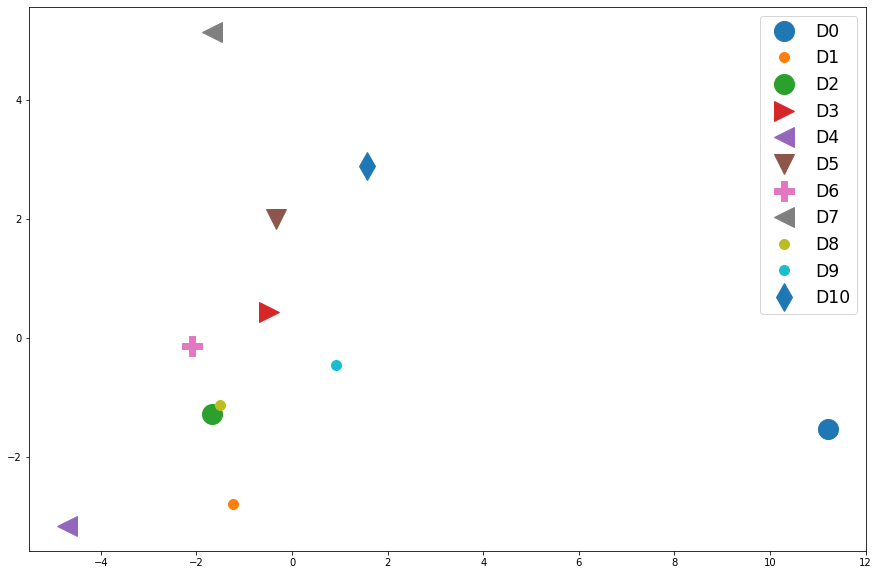

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def show_points(representation):
  pos = 0
  for title in corpus_df['title']:
    print(pos,title)
    pos+=1
  pca = PCA(n_components=2)
  ranking = np.random.normal(size=len(corpus_df[representation]))
  X = pca.fit_transform(corpus_df[representation].tolist())
  fig, ax = plt.subplots(figsize=(15, 10))
  #scatter = ax.scatter(X[:,0], X[:,1], cmap="Spectral")
  colors = ['o', '.', 'o', 'x', 'P', 'v', '*', '<', '.', '.', 'd']
  markers = ['o', '.', 'o', '>', '<', 'v', 'P', '<', '.', '.', 'd']
  for i, txt in enumerate(corpus_df['title'].tolist()):
    plt.plot(X[:,0][i], X[:,1][i], markers[i], markersize=20, label="D{0}".format(i))
    #plt.annotate("D"+str(i), (X[:,0][i], X[:,1][i]))
  plt.legend(numpoints=1,fontsize='xx-large')
  plt.show()


show_points('d2v')


##### 2.3.2.3.2 Bag-of-words

This approach does not consider the order of the words to be relevant, but their frequency. It assumes words with similar meanings will occur in similar documents, although a recent proposal uses an embeddings based approach to model the topics (Dieng et al., 2020). Topic models (Blei et al., 2003; Deerwester et al., 1990; Hofmann, 2001) are the main methods based on this approach. This second approach is used in our work since we are not only interested in representing words and documents, but we also seek structures that allows considering knowledge about the collection

In [58]:
import gensim

# Create Dictionary
dictionary = gensim.corpora.Dictionary(corpus_df['tokens'])

# Create bag-of-words
bows = [dictionary.doc2bow(text) for text in corpus_df['tokens']]

print("->",corpus_df['title'][0],":")
for word in bows[0][250:270]:
  id = word[0]
  freq = word[1]
  print(dictionary[id],"(",freq,")")

-> Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation :
Ermolayev ( 3 )
Ermolayev1 ( 1 )
Eugene ( 1 )
Evaluation ( 3 )
Excel ( 1 )
Experiment ( 2 )
Experimental ( 2 )
Experiments ( 1 )
Extensions ( 1 )
Extrac- ( 1 )
Extraction ( 5 )
Extractor ( 53 )
Extractor2 ( 1 )
Extracts ( 2 )
F. ( 3 )
FP7 ( 1 )
Fahmi ( 1 )
Fig ( 47 )
Finder ( 1 )
Fitness ( 2 )


### 2.3.3 Probabilistic Topic Models

Probabilistic Topic Models (PTM) (Blei et al., 2003; Hofmann, 2001) are statistical methods based on bag-of-words that analyze the words of the original texts to discover the themes that run through them, how those themes are connected to each other, or how they change over time. 

PTM do not require any prior annotations or labeling of the documents. The topics emerge, as hidden structures, from the analy- sis of the original texts. These structures are topic distributions, per-document topic distributions or per-document per-word topic assignments.

In turn, a topic is a distribution over terms that is biased around those words associated to a single theme. This interpretable hidden structure annotates each document in the collection and these annotations can be used to perform deeper analysis about relationships between documents.

Topic-based representations bring a lot of potential when applied over different IR tasks, as evidenced by recent works in different domains such as scholarly (Gatti et al., 2015), health (Hsin-Min et al., 2016; Nzali et al., 2017), legal (Greene and Cross, 2016; O’Neill et al., 2017), news (He et al., 2017) and social networks (Cheng et al.,2014). 

Topic modeling provides an algorithmic solution to organize and annotate large collections of textual documents according to their topics.

#### 2.3.3.1 LDA

The simplest generative topic model proposed in the state of the art is Latent Dirichlet Allocation (LDA) (Blei et al., 2003). Along with Latent Semantic Analysis (LSA) (Deerwester et al., 1990) and Probabilistic Latent Semantic Analysis (pLSA) (Hofmann, 2001) are part of the field known as topic modeling. They are well-known latent variable models for high dimensional data, such as the bag-of-words representation for textual data or any other count-based data representation. They try to capture the intuition that documents can exhibit multiple themes.

In [59]:
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

number_of_topics = 5

lda_model = gensim.models.ldamodel.LdaModel(corpus=bows,
                                           id2word=dictionary,
                                           num_topics=number_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           per_word_topics=True)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")




Topic: 0 
Words: 0.027*"topic" + 0.020*"document" + 0.017*"base" + 0.008*"distribution" + 0.008*"model" + 0.007*"similarity" + 0.007*"algorithm" + 0.006*"set" + 0.005*"datum" + 0.005*"mean"


Topic: 1 
Words: 0.015*"drug" + 0.009*"disease" + 0.006*"old" + 0.005*"PLWH" + 0.005*"medication" + 0.005*"knowledge" + 0.005*"document" + 0.004*"text" + 0.004*"create" + 0.004*"study"


Topic: 2 
Words: 0.021*"term" + 0.011*"collection" + 0.010*"document" + 0.010*"  " + 0.009*"value" + 0.009*"saturation" + 0.009*"datum" + 0.009*"paper" + 0.007*"extract" + 0.007*"result"


Topic: 3 
Words: 0.009*"synset" + 0.008*"topic" + 0.008*"document" + 0.007*"lingual" + 0.006*"category" + 0.006*"   " + 0.004*"model" + 0.004*"language" + 0.003*"algorithm" + 0.003*"base"


Topic: 4 
Words: 0.001*"document" + 0.001*"topic" + 0.001*"term" + 0.001*"base" + 0.001*"collection" + 0.000*"datum" + 0.000*"text" + 0.000*"  " + 0.000*"dataset" + 0.000*"set"




Visualize topics:

In [60]:
!pip install pyLDAvis==2.1.2
import pyLDAvis
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bows, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.142936 -0.064777       1        1  43.247497
2      0.040573  0.171527       2        1  36.759207
1     -0.130098  0.000607       3        1  18.532463
3      0.002584 -0.062019       4        1   1.456735
4     -0.055996 -0.045338       5        1   0.004098, topic_info=           Term        Freq       Total Category  logprob  loglift
1535      topic  415.000000  415.000000  Default  30.0000  30.0000
777    document  433.000000  433.000000  Default  29.0000  29.0000
1502       term  288.000000  288.000000  Default  28.0000  28.0000
2970       drug   90.000000   90.000000  Default  27.0000  27.0000
1049    lingual   65.000000   65.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1533       tool    0.000364   73.317116   Topic5  -8.1912  -2.1118
1601       word    0.000367   79.079769   Topic5  -8.1827  -2.1790
1180      paper    0.000392  154.921233   Topic5  -8.1152  -2.7840
544   algorithm    0.000372  117.664763   Topic5  -8.1675  -2.5612
267         Fig    0.000367   86.671589   Topic5  -8.1813  -2.2693

[353 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         2  0.975681      
0         3  0.017423      
0         4  0.008711      
1         2  0.844993      
1         3  0.038409      
...     ...       ...   ...
1602      2  0.289777  work
1602      3  0.220782  work
1602      4  0.013799  work
5066      1  0.969968    ￿e
5072      1  0.956492   ￿is

[429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

Each document exhibits each topic in different proportion, and each word in each document is drawn from one of the topics, where the selected topic is chosen from the per-document distribution over topics. All the documents in a collection share the same set of topics, but each document exhibits these topics in a different proportion. Texts are described as a vector of counts with W components, where W is the number of words in the vocabulary. Each document in the corpus is modeled as a mixture over K topics, and each topic k is a distribution over the vocabulary of W words.

In [61]:
topic_vectors = []
for bow in bows:
  top_topics = (lda_model.get_document_topics(bow,minimum_probability=0.0))
  topic_vec = [top_topics[i][1] for i in range(number_of_topics)]
  topic_vectors.append(topic_vec)

corpus_df['topics'] = topic_vectors
corpus_df.head(3)

,title,text,#words,tokens,#tokens,#uni_tokens,boolean,tf,tf_idf,d2v,topics
0,Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation,Synopsis of the Refinements and Extensions Compared to the Publication in the Conference Proceedings This submission is a refined and extended paper based on the ICTERI 2017 PhD Symposium paper...,12954,"[synopsis, Refinements, Extensions, compare, publication, Conference, Proceedings, submission, refined, extended, paper, base, ICTERI, phd, symposium, paper, Kosa, et, al, fact, submission, totall...",6342,1618,"{'synopsis': True, 'Refinements': True, 'Extensions': True, 'compare': True, 'publication': True, 'Conference': True, 'Proceedings': True, 'submission': True, 'refined': True, 'extended': True, 'p...","{'synopsis': 1, 'Refinements': 1, 'Extensions': 1, 'compare': 21, 'publication': 3, 'Conference': 1, 'Proceedings': 1, 'submission': 2, 'refined': 2, 'extended': 1, 'paper': 44, 'base': 43, 'ICTER...","{'synopsis': 0.0003780976462942874, 'Refinements': 0.0003780976462942874, 'Extensions': 0.0003780976462942874, 'compare': 0.0003155966218686256, 'publication': 0.0002867245996075286, 'Conference':...","[1.8876443, -0.8634335, -16.34512, 13.771379, -1.2340014]","[5.7201378e-05, 3.681213e-05, 0.99986476, 2.242519e-05, 1.8815845e-05]"
1,Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph,"Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph Ahmet Soylu1, Oscar Corcho2, Brian Elvesæter1, Carlos Badenes-Olmedo2, Francisc...",5827,"[enhance, Public, Procurement, European, Union, Constructing, exploit, Integrated, Knowledge, Graph, Ahmet, Soylu1, Oscar, Corcho2, Brian, Elvesæter1, Carlos, Badenes, Olmedo2, Francisco, Yedro2, ...",3406,1290,"{'enhance': True, 'Public': True, 'Procurement': True, 'European': True, 'Union': True, 'Constructing': True, 'exploit': True, 'Integrated': True, 'Knowledge': True, 'Graph': True, 'Ahmet': True, ...","{'enhance': 9, 'Public': 9, 'Procurement': 9, 'European': 5, 'Union': 3, 'Constructing': 1, 'exploit': 1, 'Integrated': 8, 'Knowledge': 11, 'Graph': 11, 'Ahmet': 1, 'Soylu1': 1, 'Oscar': 1, 'Corch...","{'enhance': 0.004504619151540172, 'Public': 0.006336188330941086, 'Procurement': 0.006336188330941086, 'European': 0.0014850277622995888, 'Union': 0.0011444066213713397, 'Constructing': 0.00070402...","[1.6595398, -9.840459, -12.158843, 6.647979, -4.024708]","[0.000119926975, 6.964687e-05, 0.99973357, 4.1799685e-05, 3.503087e-05]"
2,Drugs4Covid: Making drug information available from scientific publications,"Drugs4Covid: Making drug information available from scientific publications Carlos Badenes-Olmedo1, David Chaves-Fraga1, Mar´ıa Poveda-Villal´on1, Ana Iglesias-Molina1, Pablo Calleja1, Socorro Ber...",5417,"[Drugs4Covid, make, drug, information, available, scientific, publication, Carlos, Badenes, Olmedo1, David, Chaves, Fraga1, Mar´ıa, Poveda, Villal´on1, Ana, Iglesias, Molina1, Pablo, Calleja1, Soc...",3260,1367,"{'Drugs4Covid': True, 'make': True, 'drug': True, 'information': True, 'available': True, 'scientific': True, 'publication': True, 'Carlos': True, 'Badenes': True, 'Olmedo1': True, 'David': True, ...","{'Drugs4Covid': 24, 'make': 2, 'drug': 71, 'information': 11, 'available': 12, 'scientific': 14, 'publication': 9, 'Carlos': 1, 'Badenes': 10, 'Olmedo1': 1, 'David': 1, 'Chaves': 1, 'Fraga1': 1, '...","{'Drugs4Covid': 0.017653216732257945, 'make': 0.00019537038718928502, 'drug': 0.03712794924813748, 'information': 0.0, 'available': 0.00035083501768463167, 'scientific': 0.004344298393711264, 'pub...","[1.2999653, -9.134557, -10.952589, 5.944156, -3.9267771]","[0.002306211, 0.9975591, 5.4518772e-05, 4.3636315e-05, 3.6599005e-05]"


0 Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation
1 Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph
2 Drugs4Covid: Making drug information available from scientific publications
3 Distributing Text Mining tasks with librAIry
4 Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms
5 An initial Analysis of Topic-based Similarity among Scientific Documents based on their Rhetorical Discourse Parts
6 Efficient Clustering from Distributions over Topics
7 Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets
8 Scalable Cross-lingual Document Similarity through Language-specific Concept Hierarchies
9 Potentially inappropriate medications in older adults living with HIV
10 Semantic Saturation in Retrospective Text Document  Collections


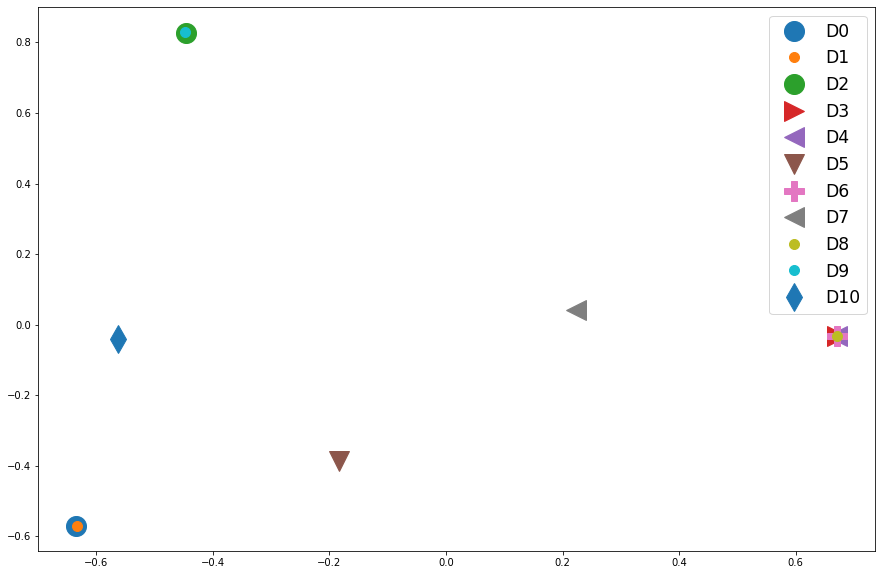

In [62]:
show_points('topics')

In [63]:
from gensim.models import CoherenceModel

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  # Compute Perplexity
  print('\nPerplexity: ', lda_model.log_perplexity(bows))  # a measure of how good the model is. lower the better.

  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_df['tokens'], dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.595129924140884

Coherence Score:  0.4451044016999169


# 3.- Techniques for Probabilistic Topic Models

In order to train a LDA model it is necessary to provide a fixed number of topics across the corpus. Each topic is drawn from a Dirichlet distribution with parameter β, while each document’s mixture is sampled from a Dirichlet distribution with parameter α. These two priors, α and β, set the probability that a document or a word, respec- tively, contains more than one topic. Along with the number of topics they are also known as hyper-parameters of a LDA model and they have to be tuned when training a model. There are other parameters common to learning models, such as the number of iterations through the corpus when inferring the topic distribution, or related to the online learning mode of LDA (Hoffman et al., 2010), for example the number of docu- ments to be iterated through for each update, that can also be fine-tuned. However α, β and the number of topics are the ones that mainly define the behavior of the model for distributing the topics and therefore crucial when creating the model. The following code shows the topic distributions of the example corpus. An LDA model was trained with 5 topics to reflect the four research areas of this thesis and the experiments performed; α equals to 1.0 (higher than usual) because the documents are likely to contain more than one topic; and β equals to 0.01 to force to distribute the words among topics in a non-homogeneous way. Given the topics of the model, it can be seen how documents present strongly unbalanced distributions with respect to some of the topics. The small size of the corpus and the specialization of the articles causes this behavior.

In [64]:
pos = 0
for topic_distribution in corpus_df['topics']:
  print(corpus_df['title'][pos])
  pos += 1
  for value in topic_distribution:
    print("%.5f" % value)
  

Cross-Evaluation of Term Extraction Tools by Measuring Terminological Saturation
0.00006
0.00004
0.99986
0.00002
0.00002
Enhancing Public Procurement in the European Union through Constructing and Exploiting an Integrated Knowledge Graph
0.00012
0.00007
0.99973
0.00004
0.00004
Drugs4Covid: Making drug information available from scientific publications
0.00231
0.99756
0.00005
0.00004
0.00004
Distributing Text Mining tasks with librAIry
0.99954
0.00016
0.00012
0.00010
0.00008
Large-Scale Semantic Exploration of Scientific Literature using Topic-based Hashing Algorithms
0.99988
0.00004
0.00003
0.00003
0.00002
An initial Analysis of Topic-based Similarity among Scientific Documents based on their Rhetorical Discourse Parts
0.34434
0.00017
0.65531
0.00010
0.00008
Efficient Clustering from Distributions over Topics
0.99977
0.00008
0.00006
0.00005
0.00004
Legal Documents Retrieval Across Languages: Topic Hierarchies based on synsets
0.40842
0.00030
0.00023
0.59090
0.00015
Scalable Cross-lingu

## 3.1 Document Similarity Calculation based on LDA

Since documents are described by topic distributions, the semantic similarity between two texts is based on the distance of their vector representations of the topics, which can be also seen as two probability mass functions.

In [96]:
def compare(metric,bidirectional=False):
  print("\t"+"\t".join(["D"+str(id) for id,v in enumerate(corpus_df['topics'])]))
  for id1, v1 in enumerate(corpus_df['topics']):
    l1 = []
    l2 = []
    for id2, v2 in enumerate(corpus_df['topics']):
      d1 = metric(np.array(v1),np.array(v2))
      d2 = metric(np.array(v2),np.array(v1))
      l1.append(d1)
      l2.append(d2)      
    print("D"+str(id1)+"\t&"+"\t&".join([str(round(elem, 2) ) for elem in l1]))    
    if (bidirectional):
      print("D"+str(id1)+"\t&"+"\t&".join([str(round(elem, 2) ) for elem in l2]))

print("comparison ready!")

comparison ready!


### 3.1.1 Kullback-Liebler (KL) divergence:

In [91]:
import numpy as np

def kl_divergence(p, q):
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))

compare(kl_divergence,True)

	D0	D1	D2	D3	D4	D5	D6	D7	D8	D9	D10
D0	&0.0	&0.0	&9.81	&9.02	&10.36	&0.42	&9.73	&8.4	&9.72	&9.34	&0.48
D0	&0.0	&0.0	&10.19	&9.76	&9.77	&2.72	&9.77	&9.64	&9.77	&10.2	&3.2
D1	&0.0	&0.0	&9.81	&9.02	&10.36	&0.42	&9.73	&8.39	&9.72	&9.34	&0.47
D1	&0.0	&0.0	&9.55	&9.02	&9.03	&2.47	&9.03	&8.97	&9.03	&9.57	&2.96
D2	&10.19	&9.55	&0.0	&8.69	&10.04	&8.66	&9.41	&8.08	&9.41	&0.0	&0.97
D2	&9.81	&9.81	&0.0	&6.07	&6.07	&7.88	&6.07	&7.73	&6.07	&0.0	&5.44
D3	&9.76	&9.02	&6.07	&0.0	&0.0	&1.06	&0.0	&0.89	&0.0	&8.66	&8.47
D3	&9.02	&9.02	&8.69	&0.0	&0.0	&5.27	&0.0	&4.79	&0.0	&8.72	&8.24
D4	&9.77	&9.03	&6.07	&0.0	&0.0	&1.07	&0.0	&0.89	&0.0	&8.67	&8.48
D4	&10.36	&10.36	&10.04	&0.0	&0.0	&6.15	&0.0	&5.58	&0.0	&10.08	&9.59
D5	&2.72	&2.47	&7.88	&5.27	&6.15	&0.0	&5.73	&5.17	&5.73	&8.46	&2.59
D5	&0.42	&0.42	&8.66	&1.06	&1.07	&0.0	&1.06	&5.2	&1.06	&8.69	&2.89
D6	&9.77	&9.03	&6.07	&0.0	&0.0	&1.06	&0.0	&0.89	&0.0	&8.67	&8.47
D6	&9.73	&9.73	&9.41	&0.0	&0.0	&5.73	&0.0	&5.21	&0.0	&9.45	&8.96
D7	&9.64	&8.97	&7.73	&4.79	&5.5

### 3.1.2 Jensen-Shannon (JS) Divergence

In [92]:
import numpy as np
import scipy as sp

def js_divergence(p,q,base=np.e):
  p, q = np.asarray(p), np.asarray(q)
  p, q = p/p.sum(), q/q.sum()
  m = 1./2*(p + q)
  return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

compare(js_divergence)

	D0	D1	D2	D3	D4	D5	D6	D7	D8	D9	D10
D0	&0.0	&0.0	&0.69	&0.69	&0.69	&0.14	&0.69	&0.69	&0.69	&0.69	&0.15
D1	&0.0	&0.0	&0.69	&0.69	&0.69	&0.14	&0.69	&0.69	&0.69	&0.69	&0.15
D2	&0.69	&0.69	&0.0	&0.68	&0.68	&0.69	&0.68	&0.68	&0.68	&0.0	&0.29
D3	&0.69	&0.69	&0.68	&0.0	&0.0	&0.31	&0.0	&0.27	&0.0	&0.69	&0.69
D4	&0.69	&0.69	&0.68	&0.0	&0.0	&0.31	&0.0	&0.27	&0.0	&0.69	&0.69
D5	&0.14	&0.14	&0.69	&0.31	&0.31	&0.0	&0.31	&0.43	&0.31	&0.69	&0.25
D6	&0.69	&0.69	&0.68	&0.0	&0.0	&0.31	&0.0	&0.27	&0.0	&0.69	&0.69
D7	&0.69	&0.69	&0.68	&0.27	&0.27	&0.43	&0.27	&0.0	&0.27	&0.69	&0.69
D8	&0.69	&0.69	&0.68	&0.0	&0.0	&0.31	&0.0	&0.27	&0.0	&0.69	&0.69
D9	&0.69	&0.69	&0.0	&0.69	&0.69	&0.69	&0.69	&0.69	&0.69	&0.0	&0.29
D10	&0.15	&0.15	&0.29	&0.69	&0.69	&0.25	&0.69	&0.69	&0.69	&0.29	&0.0


### 3.1.3 Hellinger (He) distance

In [93]:
import numpy as np
from scipy.linalg import norm

def hellinger_distance(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

compare(hellinger_distance)

	D0	D1	D2	D3	D4	D5	D6	D7	D8	D9	D10
D0	&0.0	&0.0	&0.99	&0.99	&0.99	&0.43	&0.99	&0.99	&0.99	&0.99	&0.46
D1	&0.0	&0.0	&0.99	&0.99	&0.99	&0.43	&0.99	&0.99	&0.99	&0.99	&0.45
D2	&0.99	&0.99	&0.0	&0.97	&0.97	&0.98	&0.97	&0.97	&0.97	&0.02	&0.62
D3	&0.99	&0.99	&0.97	&0.0	&0.01	&0.64	&0.0	&0.59	&0.0	&0.99	&0.98
D4	&0.99	&0.99	&0.97	&0.01	&0.0	&0.64	&0.0	&0.6	&0.0	&0.99	&0.99
D5	&0.43	&0.43	&0.98	&0.64	&0.64	&0.0	&0.64	&0.78	&0.64	&0.99	&0.59
D6	&0.99	&0.99	&0.97	&0.0	&0.0	&0.64	&0.0	&0.6	&0.0	&0.99	&0.99
D7	&0.99	&0.99	&0.97	&0.59	&0.6	&0.78	&0.6	&0.0	&0.6	&0.98	&0.98
D8	&0.99	&0.99	&0.97	&0.0	&0.0	&0.64	&0.0	&0.6	&0.0	&0.99	&0.99
D9	&0.99	&0.99	&0.02	&0.99	&0.99	&0.99	&0.99	&0.98	&0.99	&0.0	&0.61
D10	&0.46	&0.45	&0.62	&0.98	&0.99	&0.59	&0.99	&0.98	&0.99	&0.61	&0.0


### 3.1.4 S2JSD distance

In [97]:
def s2jsd_distance(p,q):
  return np.sqrt(2*js_divergence(p,q))

compare(s2jsd_distance)

	D0	D1	D2	D3	D4	D5	D6	D7	D8	D9	D10
&0.0&0.0&1.18&1.18&1.18&0.52&1.18&1.18&1.18&1.18&0.55
&0.0&0.0&1.18&1.18&1.18&0.52&1.18&1.18&1.18&1.18&0.55
&1.18&1.18&0.0&1.17&1.17&1.17&1.17&1.17&1.17&0.03&0.76
&1.18&1.18&1.17&0.0&0.01&0.79&0.01&0.73&0.01&1.18&1.18
&1.18&1.18&1.17&0.01&0.0&0.79&0.0&0.73&0.0&1.18&1.18
&0.52&0.52&1.17&0.79&0.79&0.0&0.79&0.93&0.79&1.18&0.71
&1.18&1.18&1.17&0.01&0.0&0.79&0.0&0.73&0.0&1.18&1.18
&1.18&1.18&1.17&0.73&0.73&0.93&0.73&0.0&0.73&1.18&1.17
&1.18&1.18&1.17&0.01&0.0&0.79&0.0&0.73&0.0&1.18&1.18
&1.18&1.18&0.03&1.18&1.18&1.18&1.18&1.18&1.18&0.0&0.76
&0.55&0.55&0.76&1.18&1.18&0.71&1.18&1.17&1.18&0.76&0.0


# References

* Manning, C. D., Raghavan, P., and Schutze, H. (2008). Introduction to Information Retrieval. Cambridge University Press.
* Porter, M. F. (1997). An Algorithm for Suffix Stripping, page 313–316. Morgan Kauf- mann Publishers Inc.
* Harmon, D. K. (1996). Overview of the Third Text Retrieval Conference (TREC-3). DIANE Publishing Company.
* Salton, G. and McGill, M. J. (1983). Introduction to Modern Information Retrieval. McGraw-Hill, Inc
* Hearst, M. a. and Hall, S. (1999). Untangling Text Data Mining. In the 37th Annual Meeting of the Association for Computational Linguistics, pages 1–13
* Lee, J. H. (1995). Combining multiple evidence from different properties of weighting schemes. In Proceedings of the 18th Annual International ACM SIGIR Conference on Research and Development in Information Retrieval, SIGIR ’95, page 180–188. Association for Computing Machinery.
* Mikolov, T., Sutskever, I., Chen, K., Corrado, G., and Dean, J. (2013). Distributed Representations of Words and Phrases and their Compositionality. Proceedings of the 26th International Conference on Neural Information Processing Systems, 2:3111– 3119.
* Pennington, J., Socher, R., and Manning, C. (2014). GloVe: Global vectors for word representation. In Proceedings of the 2014 Conference on Empirical Methods in Natu- ral Language Processing (EMNLP), pages 1532–1543. Association for Computational Linguistics.
* Dieng, A. B., Ruiz, F., and Blei, D. (2020). Topic modeling in embedding spaces. Transactions of the Association for Computational Linguistics, 8:439–453
* Blei, D., Ng, A., and Jordan, M. (2003). Latent Dirichlet Allocation. Journal of Machine Learning Research, 3(4-5):993–1022
* Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., and Harshman, R. (1990). Indexing by Latent Semantic Analysis. Journal of the American Society for Information Science, 41(6):391–407.
* Hofmann, T. (2001). Unsupervised Learning by Probabilistic Latent Semantic Analysis. Machine Learning, 42(1-2):177–196.
* Gatti, C., Brooks, J., and Nurre, S. (2015). A Historical Analysis of the Field of OR/MS using Topic Models. CoRR, abs/1510.0.
* Hsin-Min, L., Chih-Ping, W., and Fei-Yuan, C. (2016). Modeling healthcare data using multiple-channel latent Dirichlet allocation. Journal of Biomedical Informatics, 60:210–223.
* Nzali, T., Donald, M., Bringay, S., Lavergne, C., Mollevi, C., and Opitz, T. (2017). What Patients Can Tell Us: Topic Analysis for Social Media on Breast Cancer. JMIR medical informatics, 5(3):e23.
* Greene, D. and Cross, J. (2016). Exploring the political agenda of the european par- liament using a dynamic topic modeling approach. Political Analysis, 25(1):77–94.
* O’Neill, J., Robin, C., O’Brien, L., and Buitelaar, P. (2017). An analysis of topic modelling for legislative texts. CEUR Workshop Proceedings, 2143.
* He, J., Li, L., and Wu, X. (2017). A self-adaptive sliding window based topic model for non-uniform texts. In Proceedings - IEEE International Conference on Data Mining, ICDM, volume 2017-Novem, pages 147–156.
* Cheng, X., Yan, X., Lan, Y., and Guo, J. (2014). BTM : Topic Modeling over Short Texts. IEEE Transactions on Knowledge and Data Engineering, 26(12):2928–2941. 



